# GRO620 - Activité procédurale 1

Dans cette activité, nous allons principalement travailler sur les éléments nécessaires pour capter une image numériquement, les transformations entre repères 2D et 3D, et l'encodage numérique de la couleur.

In [1]:
# Préambule

import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## Acquisition

### Q1.1

À partir de la figure 2.23 du livre de référence, décrivez en une phrase le rôle de chacune des étapes de la chaîne d'acquisition d'images numériques.

#### Camera body

Optics: La lentille qui dévie la lumière sur le capteur et définit la distance focale.  
Aperture: Ouverture à travers laquelle la lumière passe.  
Shutter: Dispositif qui permet à la lumière de passer pour un temps d'exposition déterminé.  

#### Sensor chip

Sensor (CCD/CMOS): Convertit la lumière en voltage électrique.  
Gain (ISO): Gain sur le voltage qui définit la sensibilité du capteur.  
A/D: Convertisseur analogue / digital.

#### DSP

Demosaic: Estimation des couleurs manquantes des pixels de l'image. Passage de matrice de Bayer à RGB.  
Sharppen: Augmente les contrastes pour atténuer l'effet du moyennage fait à l'étape précédente.  
White balance: Réajustement du blanc pour contrer l'effet jaunâtre de l'éclairage.  
Gamma / curve: Transformation pour ajuster la distribution de la couleur aux plages non-linéraire visibles par l'oeil humain.  
Compress: Compression de l'image.    


### Q1.2

Quelle est la différence entre paramètres intrinsèques et extrinsèques du caméra ? Décrivez chaque type en une phrase. 

**Intrinsèque :** Paramètres propres à la caméra qui sont toujours constants. Matrice K. Caractéristiques optiques de la caméra.

**Extrinsèque :** Paramètres qui décrivent la position de la caméra par rapport à son environnement. Matrice de transformation.

### Q1.3

Soit la configuration intrinsèque d'une caméra représentée par la matrice $K$ :

$$
K = \begin{bmatrix} 
 620 &   0 & 1024 \\ 
   0 & 620 &  512 \\ 
   0 &   0 &    1 
\end{bmatrix}
$$

Le capteur de cette caméra a une taille de 30 mm x 15 mm.

Pouvez-vous estimer la distance focale en mm de la lentille de cette caméra à partir de la matrice $K$ ?

In [2]:
K = np.array([[620.,   0., 1024.],
              [  0., 620.,  512.],
              [  0.,   0.,    1.]
])

fx = K[0][0]
pixel_size = 30/(K[0][2]*2) 
f = fx * pixel_size

print("Distance focale :", f, "mm")



Distance focale : 9.08203125 mm


### Q1.4

Dans le cadre de cet APP, nous considérons les caméras comme étant idéales, c'est-à-dire qu'on peut obtenir leurs caractéristiques intrinsèques et extrinsèques à partir de quelques paramètres seulement.

**a)** Qu'est-ce qui rend les vraies caméras non-idéales ? Nommez des facteurs autant pour les caractéristiques intrinsèques que extrinsèques.

- Défauts sur les caméras ou irrégularités (tolérences mécaniques) affectent f, alignement, skew. 

**b)** Que doit on faire pour obtenir les caractéristiques d'une caméra non-idéale ?

- Protocole de calibration, ex: checkerboard.

## Repères et coordonnées

### Q2.1

Supposons ces 2 repères :

![](images_doc/proc1-q2_1-frames.png)

**a)** Trouvez la matrice homogène permettant de transformer un point du repère $\{1\}$ au repère $\{0\}$.

In [3]:
T_10 = np.array([[0, 1,  0, 240], \
                 [1, 0,  0,  80], \
                 [0, 0, -1, 120], \
                 [0, 0,  0,   1]])
print("T_10:\n", T_10)


T_10:
 [[  0   1   0 240]
 [  1   0   0  80]
 [  0   0  -1 120]
 [  0   0   0   1]]


**b)** Trouvez maintenant la transformation inverse.

In [4]:
T_01 = np.linalg.inv(T_10)
print("T_01:\n", T_01)


T_01:
 [[   0.    1.    0.  -80.]
 [   1.    0.    0. -240.]
 [  -0.   -0.   -1.  120.]
 [   0.    0.    0.    1.]]


**c)** Soit le point $p_0 = [8, 5, 1]^T$, un point dans le repère $\{0\}$. Trouvez $p_1$, ses coordonnées dans le repère $\{1\}$.

In [5]:
p_0 = [8, 5, 1, 1]
p_1 = np.dot(T_01, p_0)
print(p_1)


[ -75. -232.  119.    1.]


### Q2.2

Supposons maintenant que le repère $\{1\}$ représente une caméra avec les caractéristiques intrinsèques $K$ de la question Q1.3.

**a)** Trouvez la matrice de projection P complète permettant de projeter un point $p$ décrit dans le repère $\{0\}$.

In [6]:
Rt = T_01[0:3, :]
P = np.dot(K, Rt)
print(P)

[[ 0.000e+00  6.200e+02 -1.024e+03  7.328e+04]
 [ 6.200e+02  0.000e+00 -5.120e+02 -8.736e+04]
 [ 0.000e+00  0.000e+00 -1.000e+00  1.200e+02]]


**b)** Soit le point $p_0 = [0.250, 0.010, 0.000]$. Trouvez le point $x_s$, les coordonnées du point $p_0$ perçu par la caméra.

In [7]:
p_0 = np.array([250, 10, 0, 1])

Pt = np.zeros([4, 4])
Pt[0:3, 0:4] = P[0:3, 0:4]
Pt[3, 0:4] = np.array([0, 0, 0, 1])

x_s = np.dot(Pt, p_0)
x_s = x_s/x_s[2]

print(x_s)

[6.62333333e+02 5.63666667e+02 1.00000000e+00 8.33333333e-03]


## Encodage de l'image

Pour les questions suivantes, vous aurez probablement besoin de lire la documentation de cv2.imread et matplotlib.pyplot.imshow :

[imread](https://pythonexamples.org/python-opencv-read-image-cv2-imread/)

[imshow](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html)

Le code suivant charge une image et l'affiche en ligne :

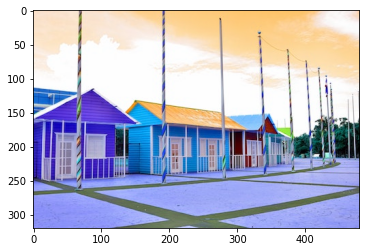

In [8]:
img_color = cv2.imread("images_doc/proc1-q3-color.jpeg")
plt.imshow(img_color)

(source de l'image: [PixaBay, Pexels](https://www.pexels.com/photo/apartment-architecture-block-blue-534124/))

### Q3.1

**a)** Ouvrez directement l'image dans un autre logiciel (le fichier se trouve dans images_doc/proc1-q3-color.jpeg) et comparez le résultat. Que remarquez vous ?

(réponse ici)

**b)** Affichez seulement le premier canal de couleurs de l'image. Pensez à analyser la composition de la matrice image que OpenCV vous retourne. Expliquez ensuite ce que vous voyez.

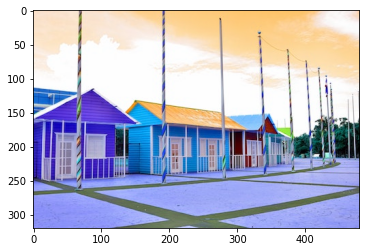

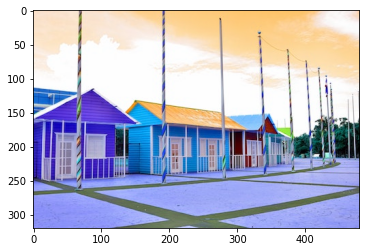

In [9]:
plt.imshow(img_color)              # Image originale
plt.figure()                       # Permet d'afficher plus d'une image dans la même cellule
plt.imshow(img_color, cmap="gray") # Le paramètre cmap n'a pas d'effet sur une image à plus d'un canal.

**c)** Transformez maintenant l'image pour que les couleurs correspondent à ce que vous voyez en dehors de Jupyter.

In [10]:
img_correcte = img_color.copy() # Permet de forcer une copie de l'image.
                                # img_correcte = img_color aurait modifié l'originale.
# ...

### Q3.2

Soit cette couleur dans l'espace Y'CbCr (on suppose chaque valeur comme étant encodée sur 8 bits) :

$c = [100, 150, 150]$

Trouvez sa valeur équivalente dans l'espace RGB.

In [11]:
c = np.array([100,150,150])

### Q3.3

**a)** Pourquoi deux appareils de capture peuvent produire des valeurs RGB différentes d'une même couleur ? 

*(réponse ici)*

**b)** Que peut-on faire pour comparer numériquement des couleurs provenant de deux capteurs différents ?

*(réponse ici)*

## Caractéristiques de la lumière

### Q4.1

Dans cette image synthétique : 

![](images_doc/proc1-q4-specular.jpg)

(source: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Specular_highlight.jpg))

**a)** Quelle(s) partie(s) correspondent à l'illumination diffuse et les reflets spéculaires ?

*(réponse ici)*

**b)** Quelle information est nécessaire pour déterminer les caractéristiques et emplacements exacts des sources de lumières dans cette image ? Répondez en utilisant des éléments de la *Bidirectional Reflectance Distribution Function* (BRDF).

*(réponse ici)*

## Reprojection 2D à 3D

### Q5.1

Supposons que le plan XY du repère $\{0\}$ est un convoyeur. Quelle serait sa largeur maximale (mesurée sur l'axe Y) si on souhaite que la caméra la capte au complet dans son image ? 

In [12]:
x_lens = 30 # mm
dist = 120 # mm

l_conv = x_lens * dist / f
print("Largeur : ", l_conv, " mm")

Largeur :  396.38709677419354  mm


### Q5.2

Soit le point $x_s = [120, 200]$, un point dans l'image perçu par la caméra décrite plus haut. On suppose que le point perçu se trouve sur le plan XY du repère $\{0\}$. Trouvez les coordonnées du point $p_0$ qui correspond à ce même point dans le repère $\{0\}$.

In [15]:
Pt_inv = np.linalg.inv(Pt)

x_rp = x_s / x_s[3]
print(x_rp)

p_0_rp = np.dot(Pt_inv, x_rp)
print(p_0_rp)

d = 1.0 / 120  
x52_s = np.array([120, 200, 1, d])
x52_c = x52_s / d
print(x52_c)

p52_0 = np.matmul(Pt_inv, x52_c)
print("\nCoordonnées : ", p52_0)

[7.948e+04 6.764e+04 1.200e+02 1.000e+00]
[250.  10.   0.   1.]
[1.44e+04 2.40e+04 1.20e+02 1.00e+00]

Coordonnées :  [179.61290323 -94.96774194   0.           1.        ]
